# Klasifikasi Normal dan Abnormal Heartbeat Menggunakan CNN 1D Berbasis CRISP-DM

### Metodologi Penelitian: CRISP-DM
Penelitian ini menggunakan metodologi CRISP-DM (Cross Industry Standard Process for Data Mining) yang terdiri dari enam tahapan utama, yaitu Business Understanding, Data Understanding, Data Preparation, Modeling, Evaluation, dan Deployment. Metodologi ini dipilih karena memberikan alur kerja yang sistematis dan terstruktur dalam pengembangan proyek data mining dan machine learning.

## 1. Business Understanding
### 1.1 Latar Belakang Permasalahan
Pada penelitian ini, fokus klasifikasi dibatasi pada dua kelas utama, yaitu
Normal dan Abnormal, sebagai bentuk skrining awal kondisi jantung. Pendekatan
ini relevan secara klinis karena pada tahap awal pemeriksaan, tenaga medis
perlu mengetahui apakah suara jantung pasien berada pada kondisi normal atau
menunjukkan kelainan.

### 1.2 Tujuan Bisnis
Tujuan bisnis dari penelitian ini adalah membangun sistem klasifikasi suara jantung yang mampu mengidentifikasi kondisi heartbeat pasien secara otomatis dan akurat sebagai sistem pendukung keputusan awal.

### 1.3 Tujuan Data Mining
Tujuan data mining dalam penelitian ini adalah:

Mempelajari karakteristik sinyal heartbeat berbasis time series

Membangun model klasifikasi berbasis deep learning

Mengevaluasi performa model dalam membedakan masing-masing kelas heartbeat


## 2. Data Understanding 
### 2.1 Sumber Dataset
Dataset yang digunakan dalam penelitian ini adalah Abnormal Heartbeat yang diperoleh dari Time Series Classification Repository (UCR). Dataset ini berasal dari rekaman suara jantung pasien yang dikumpulkan melalui aplikasi iStethoscope Pro (iPhone) dan uji klinis menggunakan stetoskop digital DigiScope.

Pada repository UCR, data tidak lagi disediakan dalam bentuk sinyal audio mentah, melainkan telah dikonversi menjadi representasi time series numerik untuk keperluan klasifikasi deret waktu.

### 2.2 Bentuk dan Representasi Data
Setiap instance pada dataset merepresentasikan satu sinyal heartbeat dalam bentuk deret waktu amplitudo yang menunjukkan perubahan sinyal terhadap waktu selama proses pemeriksaan. Seluruh sinyal pada dataset telah melalui tahapan pra-pemrosesan sebelumnya, yaitu:
- Resampling ke frekuensi 4.000 Hz
- Pemotongan (truncation) sehingga seluruh instance memiliki panjang sinyal yang sama
Dengan demikian, setiap data direpresentasikan sebagai vektor numerik dengan panjang yang konsisten dan tidak mengandung missing value.

### 2.3 Karakteristik Dataset
Karakteristik utama dataset Abnormal Heartbeat adalah sebagai berikut:
- Jumlah instance: 409 data
- Panjang time series: 3.053 titik amplitudo
- Tipe data: Numerik
- Jenis data: Time series univariat
- Format file: .ts dan .arff
Dataset ini termasuk dalam kategori time series classification

### 2.4 Kelas Target
Dataset Abnormal Heartbeat pada awalnya terdiri dari lima kelas heartbeat,
yaitu Artifact, ExtraStole, Murmur, Normal, dan ExtraHLS. Namun, pada penelitian
ini dilakukan penggabungan kelas untuk mendukung klasifikasi biner.

Pengelompokan kelas dilakukan sebagai berikut:
- Normal  → kelas 3 (Normal)
- Abnormal → kelas 0 (Artifact), 1 (ExtraStole), 2 (Murmur), dan 4 (ExtraHLS)

Dengan demikian, penelitian ini difokuskan pada klasifikasi Normal dan Abnormal
heartbeat.

### 2.5 Pemahaman Masalah Data
Berdasarkan karakteristik dataset, permasalahan yang dihadapi merupakan klasifikasi multikelas berbasis time series. Karena data sudah berupa deret waktu numerik hasil pra-pemrosesan, maka penelitian ini tidak menggunakan ekstraksi fitur audio seperti MFCC. Sebagai gantinya, data time series akan diproses secara langsung menggunakan model Convolutional Neural Network 1 Dimensi (CNN 1D) yang mampu mempelajari pola temporal secara end-to-end.


# Load Library + Persiapan

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, classification_report 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping
import seaborn as sns
import joblib
from scipy.signal import butter, filtfilt
import os

# data understanding 

In [3]:
df_train = pd.read_csv("prepared_data/train_final.csv")
df_valid = pd.read_csv("prepared_data/valid_initial.csv")

print("Train Final:", df_train.shape)
df_train.head()

Train Final: (245, 18531)


,att1,att2,att3,att4,att5,att6,att7,att8,att9,att10,...,att18522,att18523,att18524,att18525,att18526,att18527,att18528,att18529,att18530,target
0,-0.020874,-0.045197,-0.043945,-0.049011,-0.046600,-0.048004,-0.045563,-0.041962,-0.037170,-0.029541,...,-0.044037,-0.041382,-0.040192,-0.036194,-0.034424,-0.032532,-0.032501,-0.031982,-0.033783,Abnormal
1,-0.004303,-0.009003,-0.008728,-0.009918,-0.009949,-0.010681,-0.010773,-0.011200,-0.011230,-0.011169,...,0.016815,0.016846,0.016754,0.015839,0.015930,0.015961,0.016205,0.016357,0.017792,Abnormal
2,-0.006073,-0.012054,-0.009979,-0.010742,-0.009888,-0.010406,-0.010101,-0.009979,-0.010162,-0.010315,...,-0.006775,0.001740,0.010071,0.017914,0.025574,0.032959,0.039673,0.044739,0.050018,Abnormal
3,0.007202,0.015594,0.013245,0.015594,0.015015,0.017792,0.018250,0.020660,0.021240,0.022797,...,0.040466,0.037994,0.036011,0.033295,0.032074,0.030304,0.030426,0.030212,0.031219,Abnormal
4,-0.024231,-0.051056,-0.045929,-0.049835,-0.048828,-0.049316,-0.048401,-0.047913,-0.046051,-0.045837,...,-0.277618,-0.294800,-0.303314,-0.309082,-0.314179,-0.310944,-0.304504,-0.298065,-0.282532,Abnormal


## Informasi Data

In [4]:
df_train.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 245 entries, 0 to 244
Columns: 18531 entries, att1 to target
dtypes: float64(18530), object(1)
memory usage: 34.6+ MB


## Distribusi Kelas

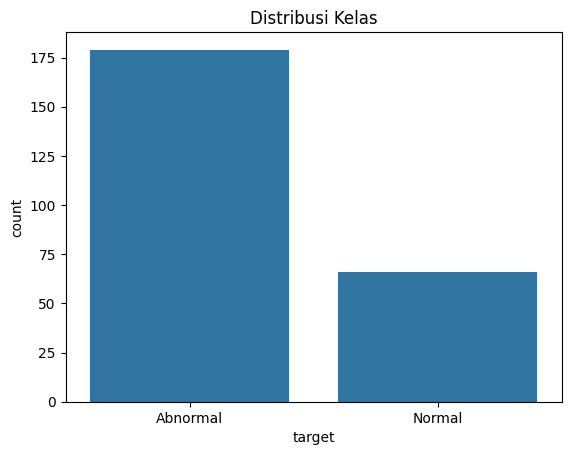

target
Abnormal    179
Normal       66
Name: count, dtype: int64

In [5]:
sns.countplot(x=df_train['target'])
plt.title("Distribusi Kelas")
plt.show()

df_train['target'].value_counts()


## Statistik Deskriptif

In [6]:
df_train.describe().T


,count,mean,std,min,25%,50%,75%,max
att1,245.0,0.007396,0.058230,-0.100464,-0.005798,0.000519,0.007202,0.508087
att2,245.0,0.011563,0.126253,-0.653076,-0.011414,0.001160,0.014374,0.999969
att3,245.0,0.010803,0.110283,-0.577881,-0.009766,0.001312,0.013245,0.887634
att4,245.0,0.012401,0.111660,-0.361969,-0.011200,0.001984,0.013886,0.943298
att5,245.0,0.008873,0.102370,-0.336578,-0.011444,0.001740,0.011841,0.844208
...,...,...,...,...,...,...,...,...
att18526,245.0,0.003977,0.053847,-0.314179,-0.008453,-0.000458,0.015625,0.356995
att18527,245.0,0.003362,0.053838,-0.310944,-0.009369,-0.000244,0.014496,0.357971
att18528,245.0,0.002771,0.054147,-0.314697,-0.009583,-0.000336,0.013184,0.356659
att18529,245.0,0.001474,0.056842,-0.355682,-0.009552,-0.000610,0.012085,0.353302


## Heatmap Korelasi (Sampling 300 fitur untuk menghindari MemoryError)

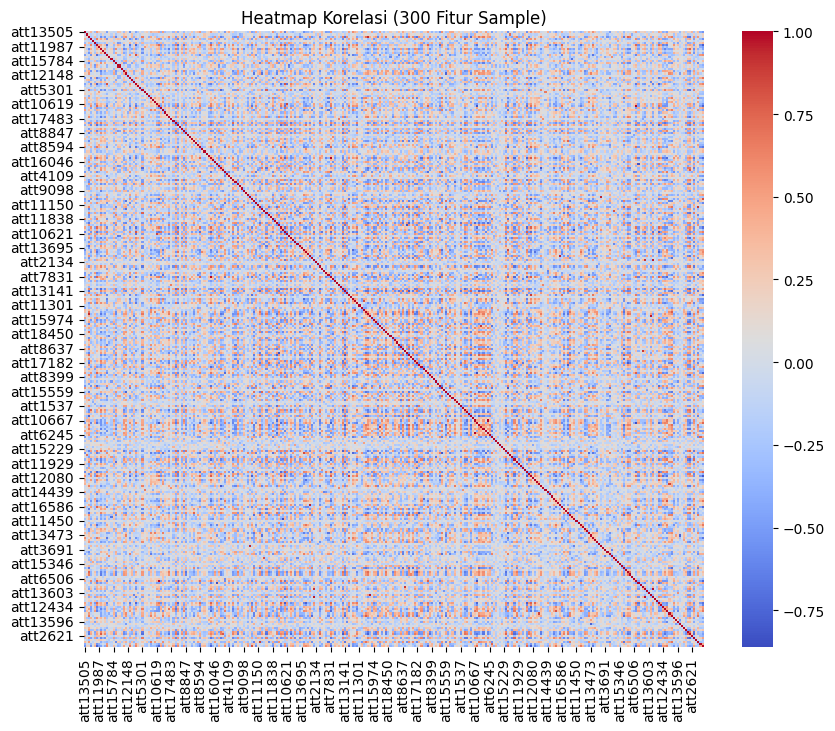

In [7]:
sampled_features = df_train.drop(columns=['target']).sample(n=300, axis=1)
corr = sampled_features.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr, cmap='coolwarm')
plt.title("Heatmap Korelasi (300 Fitur Sample)")
plt.show()


# Data Preparation
## Split 80:20 untuk Train–Test

In [8]:
X = df_train.drop(columns=["target"])
y = df_train["target"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

X_train.shape, X_test.shape

((196, 18530), (49, 18530))

In [9]:
def butter_highpass(cutoff, fs, order=5):
    """Membuat koefisien filter Butterworth High-Pass."""
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    return b, a

def apply_baseline_correction(data, cutoff_freq=0.5, fs=1000):
    """Menerapkan koreksi baseline pada setiap sampel data."""
    # Asumsi data adalah DataFrame atau numpy array, di mana setiap baris adalah 1 sampel
    b, a = butter_highpass(cutoff_freq, fs)
    
    corrected_data = np.zeros_like(data)
    
    # Iterasi melalui setiap sampel (baris)
    for i in range(data.shape[0]):
        # filtfilt memastikan filter zero-phase shift
        corrected_data[i, :] = filtfilt(b, a, data[i, :])
        
    return corrected_data

In [10]:
# Asumsi: Sampling Rate (fs) Anda adalah 1000 Hz, Cutoff di 0.5 Hz
# Jika Anda tahu sampling rate data Anda, GANTI 'fs = 1000'
FS = 1000

# 1. Terapkan Koreksi Baseline
# Asumsi: 'att1' hingga 'att18530' adalah sinyal Anda
X_train_clean = apply_baseline_correction(X_train.values, fs=FS)
X_test_clean = apply_baseline_correction(X_test.values, fs=FS)
X_valid_clean = apply_baseline_correction(df_valid.drop(columns=['target']).values, fs=FS)


# 2. Lanjutkan dengan Scaling (Gunakan data yang sudah bersih)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_clean) # GUNAKAN X_train_clean
X_test_scaled = scaler.transform(X_test_clean)     # GUNAKAN X_test_clean
X_valid_scaled = scaler.transform(X_valid_clean)   # GUNAKAN X_valid_clean

# ... Lanjutkan ke Reshaping CNN dan Training

## Scaling

In [11]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_valid_scaled = scaler.transform(df_valid.drop(columns=['target']))

joblib.dump(scaler, "scaler.pkl")


['scaler.pkl']

## Reshape untuk CNN

In [12]:
X_train_cnn = np.expand_dims(X_train_scaled, axis=-1)
X_test_cnn = np.expand_dims(X_test_scaled, axis=-1)
X_valid_cnn = np.expand_dims(X_valid_scaled, axis=-1)

y_train_cat = pd.get_dummies(y_train).values
y_test_cat  = pd.get_dummies(y_test).values
y_valid_cat = pd.get_dummies(df_valid["target"]).values

X_train_cnn.shape


(196, 18530, 1)

# Modeling (CNN)

In [13]:
from keras.layers import GlobalAveragePooling1D

model = Sequential([
    Conv1D(32, 3, activation='relu', input_shape=(X_train_cnn.shape[1], 1)),
    BatchNormalization(),
    MaxPooling1D(2),

    Conv1D(64, 3, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(2),

    Conv1D(128, 3, activation='relu'),
    BatchNormalization(),

    # Ganti Flatten() dengan GlobalAveragePooling1D()
    GlobalAveragePooling1D(), # Outputnya hanya 128 (sama dengan jumlah filter terakhir)
    # Tidak perlu Dropout karena sudah ada Global Pooling
    
    # Dense Layer sekarang hanya perlu mengalokasikan (128, 2)
    Dense(2, activation='softmax')
])

model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

c:\Users\Asus\miniconda3\envs\psd\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [25]:
# Di notebook Anda (setelah X_train_cnn dibuat)
from imblearn.over_sampling import SMOTE 
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

# 1. Definisikan strategi balancing
# Ubah bentuk data Anda kembali menjadi 2D (seperti X_train_scaled) untuk SMOTE
X_train_2d = X_train_cnn.reshape(X_train_cnn.shape[0], X_train_cnn.shape[1])
y_train_label = np.argmax(y_train_cat, axis=1) # Dapatkan label 0/1

# 2. Terapkan SMOTE (Oversampling pada kelas minoritas: Normal/1)
oversample = SMOTE(sampling_strategy='minority', random_state=42)
X_train_resampled, y_train_resampled = oversample.fit_resample(X_train_2d, y_train_label)

# 3. Ubah kembali ke bentuk 3D dan OHE untuk CNN
X_train_cnn_resampled = np.expand_dims(X_train_resampled, axis=-1)
y_train_cat_resampled = to_categorical(y_train_resampled)

# Latih Model Anda dengan data SEIMBANG:
# history = model.fit(X_train_cnn_resampled, y_train_cat_resampled, ...)

In [14]:
class_weights_new = {
    # Bobot Kelas 0 (Mayoritas) = 1.0 (bobot standar)
    0: 1.0, 
    # Bobot Kelas 1 (Minoritas) = Rasio (2.77) atau sedikit lebih rendah
    1: 1.8}

## Training

In [30]:
early = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    X_train_cnn, y_train_cat,
    validation_data=(X_test_cnn, y_test_cat),
    epochs=25,
    batch_size=16,
    callbacks=[early],
)

Epoch 1/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 43s 3s/step - accuracy: 0.7908 - loss: 0.4643 - val_accuracy: 0.6122 - val_loss: 0.6925
Epoch 2/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 45s 3s/step - accuracy: 0.7806 - loss: 0.4612 - val_accuracy: 0.7143 - val_loss: 0.5862
Epoch 3/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 79s 3s/step - accuracy: 0.7704 - loss: 0.4600 - val_accuracy: 0.7347 - val_loss: 0.6577
Epoch 4/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 75s 3s/step - accuracy: 0.8010 - loss: 0.4364 - val_accuracy: 0.7143 - val_loss: 0.5837
Epoch 5/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 42s 3s/step - accuracy: 0.7908 - loss: 0.4634 - val_accuracy: 0.7143 - val_loss: 0.6196
Epoch 6/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 39s 3s/step - accuracy: 0.8163 - loss: 0.4565 - val_accuracy: 0.7551 - val_loss: 0.6304
Epoch 7/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 54s 4s/step - accuracy: 0.7347 - loss: 0.4975 - val_accuracy: 0.7347 - val_loss: 0.7711
Epoch 8/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 63s 3s/step - accuracy: 0.7755 - loss: 0.4483 - val_accuracy: 0.7347 - val_loss:

In [31]:
test_loss, test_acc = model.evaluate(X_test_cnn, y_test_cat)
print("Test Accuracy:", test_acc)
print("Test Loss:", test_loss)


2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step - accuracy: 0.7143 - loss: 0.5837
Test Accuracy: 0.7142857313156128
Test Loss: 0.5837158560752869


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 305ms/step


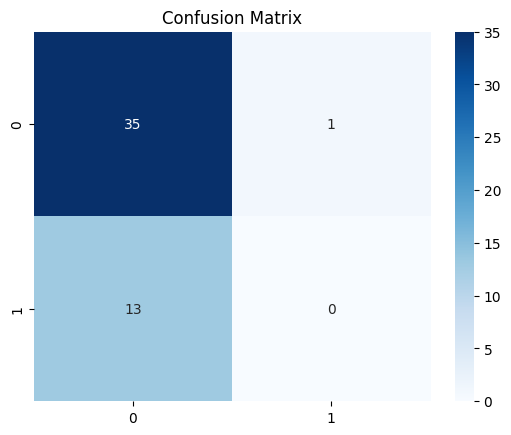

              precision    recall  f1-score   support

           0       0.73      0.97      0.83        36
           1       0.00      0.00      0.00        13

    accuracy                           0.71        49
   macro avg       0.36      0.49      0.42        49
weighted avg       0.54      0.71      0.61        49



In [32]:


y_pred = np.argmax(model.predict(X_test_cnn), axis=1)
y_true = np.argmax(y_test_cat, axis=1)

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

print(classification_report(y_true, y_pred))


In [18]:
# Pastikan Anda telah mengimpor joblib: import joblib
# Model
model.save("cnn_abnormal_heartbeat.h5")
print("Model CNN berhasil disimpan sebagai cnn_abnormal_heartbeat.h5")

# Scaler (asumsi objek scaler Anda bernama 'scaler')
# Kode ini harus ditambahkan setelah objek 'scaler' diinisialisasi dan di-fit/transform.
# Karena scaler digunakan di app.py, ini juga harus disimpan.
try:
    # Asumsi objek scaler yang digunakan sebelumnya bernama 'scaler'
    joblib.dump(scaler, "scaler.pkl")
    print("Scaler berhasil disimpan sebagai scaler.pkl")
except NameError:
    print("Pastikan variabel 'scaler' sudah terdefinisi dan fit dengan data.")

Model CNN berhasil disimpan sebagai cnn_abnormal_heartbeat.h5
Scaler berhasil disimpan sebagai scaler.pkl


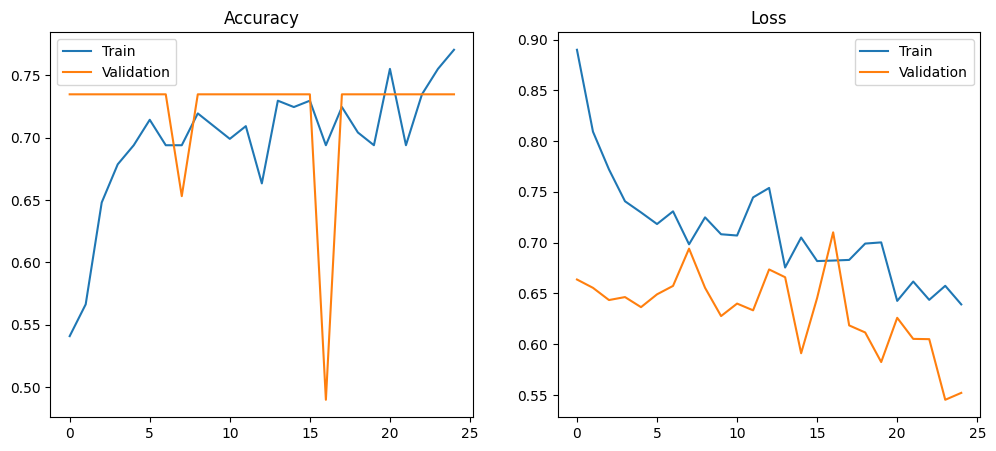

In [19]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("Accuracy")
plt.legend(["Train","Validation"])

plt.subplot(1,2,2)
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Loss")
plt.legend(["Train","Validation"])
plt.show()


In [20]:
%%writefile app.py
%%writefile app.py
import streamlit as st
import numpy as np
import pandas as pd
import joblib
from tensorflow.keras.models import load_model
from io import StringIO

# Panjang sinyal yang digunakan di training (berdasarkan kolom att1 hingga att18530)
EXPECTED_LENGTH = 18530 
TARGET_CLASSES = {0: "Abnormal", 1: "Normal"}

st.title("Abnormal Heartbeat Classification")

# --- 1. Memuat Model dan Scaler ---
@st.cache_resource
def load_resources():
    try:
        model = load_model("cnn_abnormal_heartbeat.h5")
        scaler = joblib.load("scaler.pkl")
        return model, scaler
    except FileNotFoundError:
        st.error("Error: Pastikan file 'cnn_abnormal_heartbeat.h5' dan 'scaler.pkl' ada di direktori yang sama.")
        st.stop()
    except Exception as e:
        st.error(f"Error saat memuat sumber daya: {e}")
        st.stop()

model, scaler = load_resources()

# --- 2. Input Data ---
st.header("Pilih Metode Input Data")
input_method = st.radio(
    "Pilih cara Anda ingin memasukkan data:",
    ('Unggah File CSV', 'Input Data Manual (Paste CSV)'),
    index=0 
)

df = None

if input_method == 'Unggah File CSV':
    uploaded = st.file_uploader("Unggah File CSV (1 sampel heartbeat)", type="csv")
    if uploaded:
        # Asumsi CSV tanpa header (hanya nilai sinyal)
        df = pd.read_csv(uploaded, header=None) 
        st.success("File berhasil diunggah.")

elif input_method == 'Input Data Manual (Paste CSV)':
    st.info("Tempelkan data numerik sinyal heartbeat Anda di bawah ini, dipisahkan oleh koma, baris baru, atau spasi.")
    
    text_input = st.text_area(
        "Input Data CSV Mentah (misal: 0.1, 0.2, 0.3, ...)",
        height=200
    )
    
    if text_input:
        try:
            # Fleksibel membaca pemisah (koma, spasi, atau baris baru)
            df = pd.read_csv(StringIO(text_input), sep=r'\s*,\s*|\s+', engine='python', header=None)
            st.success(f"Data berhasil diproses. Ditemukan {df.size} nilai.")
        except Exception as e:
            st.error(f"Error dalam memproses data: {e}")

# --- 3. Proses Prediksi ---
if df is not None:
    
    # 3a. Data Preparation & Flattening
    if isinstance(df, pd.Series):
        df = df.to_frame().T
    elif df.shape[0] > 1:
        # Flatten data menjadi satu baris (sample)
        st.warning("Data diinterpretasikan sebagai multiple baris. Data akan di-flatten menjadi satu sampel.")
        df = pd.DataFrame(df.values.flatten()).T
        
    # 3b. Validasi Panjang
    if df.shape[1] != EXPECTED_LENGTH:
        st.error(f"Error: Panjang sinyal ({df.shape[1]}) tidak sesuai dengan panjang yang diharapkan ({EXPECTED_LENGTH}).")
        st.stop()
        
    st.subheader("Hasil Analisis")
    st.write(f"Total Panjang Sinyal: {df.shape[1]}")
    
    try:
        # 3c. Scaling Data
        scaled = scaler.transform(df.values) 

        # 3d. Reshaping untuk CNN (dari (1, L) menjadi (1, L, 1))
        reshaped = np.expand_dims(scaled, axis=-1)

        # 3e. Prediksi
        with st.spinner('Melakukan Klasifikasi...'):
            pred = model.predict(reshaped)
            label = np.argmax(pred)
            
            # Indeks 0 = Abnormal, Indeks 1 = Normal
            prob_abnormal = pred[0][0] * 100 
            prob_normal = pred[0][1] * 100   

        st.markdown("---")
        
        # 3f. Menampilkan Hasil dengan Logika yang BENAR (0=Abnormal)
        predicted_class = TARGET_CLASSES[label]

        if predicted_class == "Normal":
            st.success(f"## 🟢 Prediksi: {predicted_class} (Keyakinan: {prob_normal:.2f}%)")
        else:
            st.error(f"## 🔴 Prediksi: {predicted_class} (Keyakinan: {prob_abnormal:.2f}%)")

        # Menampilkan probabilitas detail
        st.markdown(f"**Probabilitas:**")
        st.write(f"- Normal: {prob_normal:.2f}%")
        st.write(f"- Abnormal: {prob_abnormal:.2f}%")

    except Exception as e:
        st.error(f"Terjadi error saat prediksi: {e}")
        st.warning("Pastikan data sudah benar dan scaler.pkl cocok dengan data input.")

Overwriting app.py
